In [1]:
###########################################################################
# This notebook is authored by: Ayan Paul                                 #
# Date: January 2021                                                      #
# If you use this code or the results from this work please cite:         # 
# Emergence of universality in the transmission dynamics of COVID-19      #
# Ayan Paul, Jayanta Kumar Bhattacharjee, Aksay Pal and Sagar Chakraborty #
# arXiv:2101.12556 (https://arxiv.org/abs/2101.12556)                     # 
###########################################################################

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from scipy.signal import argrelextrema
import scipy.interpolate as interpolate
from tensorflow.keras.callbacks import Callback

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = '#121212'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
rc('font',**{'family':'serif','serif':['New Century Schoolbook']})

# For the rolling average
window_size = 7

In [2]:
def makeuniversal(df_c, country, startdate, datet_max, markers, plt, fact=1./2.):
    df_p = pd.DataFrame()
    if len(country) != len(startdate):
        print('unequal input lists')
        exit(1)
    for i in range(len(country)):
        df = ((df_c[df_c['Country/Region']==country[i]].iloc[-1:]).iloc[0][4:]).rolling(window_size).mean().dropna()
        df.index = pd.to_datetime(df.index)
        df = df[startdate[i]:]
        Nmax = df[datet_max[i]]
        t1_2 = (df.iloc[(df-Nmax*fact).abs().argsort()[:1]].index[0]-datetime.datetime.strptime(startdate[i], '%Y-%m-%d')).days
        x = np.linspace(1,len(df[:datet_max[i]]),len(df[:datet_max[i]]))/t1_2
        df_r = df[:datet_max[i]]/Nmax
        df_temp = pd.DataFrame()
        df_temp['X'] = x
        df_temp['Y'] = df_r.values
        df_temp['country'] = country[i]
        df_temp['Nmax'] = Nmax
        df_temp['t1/2'] = t1_2
        df_p = pd.concat([df_p, df_temp])
        plt.scatter(df_temp.X, df_temp.Y, label=country[i]+r' ($t_{1/2}:$ ' + str(t1_2) + ')', marker=markers[i], s=20)
    return plt, df_p

class TerminateOnBaseline(Callback):
    """ Callback that terminates training when monitored value reaches a specified baseline
    """
    def __init__(self, monitor='val_loss', patience=50):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = np.Inf
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf
        self.best_weights = None
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        value = logs.get(self.monitor)
        if epoch == 0:
            self.baseline = value/1000.
        if np.less(value, self.best):
            self.best = value
            self.wait = 0
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
        else:
            self.wait += 1
        if value is not None:
            if value <= self.baseline and self.wait >= self.patience:
                self.stopped_epoch = epoch
                print('\nepoch %d: Reached baseline, terminating training and lost patience' % epoch)
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch: ' + str(self.best_epoch))
                self.model.set_weights(self.best_weights)
            elif self.wait >= self.patience:
                self.baseline *= 2.5
                self.wait = self.patience/2
                
def runML(df, epochs=2000):
    X = ((df['X'].values)[np.newaxis]).T
    Y = df['Y'].values
    
    regressor = tf.keras.Sequential([
      tf.keras.layers.Dense(16, activation='sigmoid', input_shape=(1,)),
      tf.keras.layers.Dense(16, activation='sigmoid'),
      tf.keras.layers.Dense(16, activation='sigmoid'),
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])

    regressor.summary()
    regressor.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.01),
        loss='mse', metrics=['mse', 'mae'])
    patience = 25
    history = regressor.fit(
                X, Y,
                epochs=epochs,
                verbose=0,
                validation_split = 0.2,
                callbacks=[TerminateOnBaseline(monitor='val_loss', patience=patience)])
    
    x_pred = (np.linspace(np.min(X), 2.5, 100)[np.newaxis]).T
    y_pred = regressor.predict(x_pred)

    x_new = np.linspace(np.min(X), 2.5, 200)
    spline = interpolate.splrep(x_pred, y_pred)
    
    return x_pred, y_pred, regressor, spline


def analyze(df_c, country, startdate, datet_max, markers, plt, fact=1./2., model='gauss'):
    plt.subplot(1,2,1)
    plt, df_p = makeuniversal(df_c, country, startdate, datet_max, markers, plt, fact)

    x_new, y_new, regressor, spline = runML(df_p)
    
    plt.plot(x_new, y_new, label='Fit', color='#434343', linewidth=3)
    plt.legend(fontsize=12, loc='lower right')
    plt.xlim((0,2.5))
    plt.tick_params(axis="x", labelsize=16)
    plt.tick_params(axis="y", labelsize=16)
    plt.xlabel(r'$t/t_{1/2}$',fontsize=16)
    plt.ylabel(r'$r(t)$',fontsize=16)
    plt.grid()

    plt.subplot(1,2,2)
    df_g = pd.DataFrame()
    for i in range(len(country)):
        df_pp = pd.DataFrame()
        df_pp = df_p[df_p['country']==country[i]][['X']]
        df_pp['diff'] = df_p[df_p['country']==country[i]][['X']].diff()
        df_pp['Y'] = df_p[df_p['country']==country[i]][['Y']].diff()#.rolling(window_size).mean()
        df_pp.dropna(inplace=True)
        df_pp['Y'] = df_pp['Y']/df_pp['diff']
        df_g = pd.concat([df_g, df_pp[['X', 'Y']]])
        plt.scatter(df_pp['X'], df_pp['Y'], label=country[i], marker=markers[i], s=20)
    plt.xlim((0, 2.5))
    plt.xlabel(r'$t/t_{1/2}$', fontsize=16)
    plt.ylabel(r'$dr(\tau)/d\tau$', fontsize=16)
    ax = plt.gca()
    
    x_new = np.linspace(np.min(df_g['X'].values), 2.5, 10000)
    y_new = interpolate.splev(x_new, spline, der=1)
    plt.plot(x_new, y_new, label='Fit', color='#434343', linewidth=3)
        
    plt.legend(fontsize=12)
    plt.grid()
    plt.tick_params(axis="x", labelsize=16)
    plt.tick_params(axis="y", labelsize=16)
    
    return plt, regressor, spline,

In [3]:
# Pull in the data processed in DataScout-UniversalityClasses.ipynb
countries = pd.read_csv('data/countries.csv')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________

epoch 162: Reached baseline, terminating training and lost patience
Restoring model weights from the end of the best epoch: 111


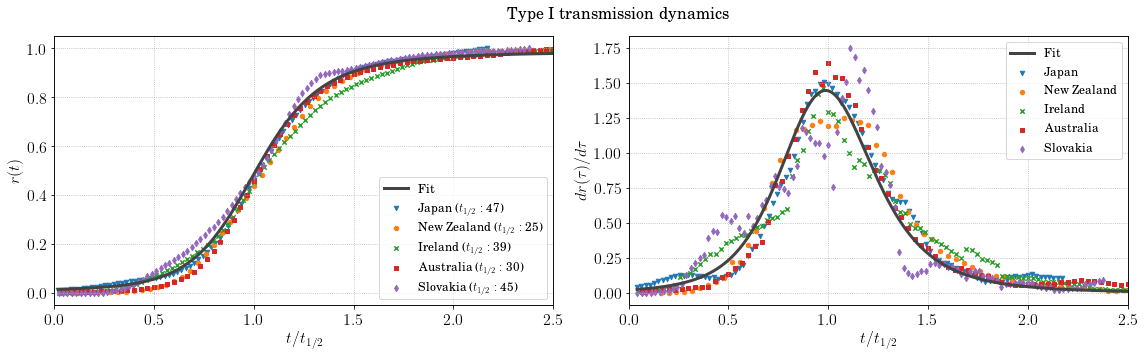

In [6]:
country = ['Japan', 'New Zealand', 'Ireland', 'Australia', 'Slovakia']
startdate = ['2020-3-1', '2020-3-10', '2020-3-10', '2020-3-1', '2020-3-1']
datet_max = ['2020-6-10', '2020-5-15', '2020-7-1', '2020-5-15', '2020-6-15']
markers = ['v', 'o', 'x', 's', 'd']

plt.figure(figsize=(16,5))
plt, regressor_t1, spline_t1 = analyze(countries, country, startdate, datet_max, markers, plt, model='PBC')

x_p = np.linspace(0,2.5,100000)
y_p = interpolate.splev(x_p, spline_t1, der=0)
y_d = interpolate.splev(x_p, spline_t1, der=1)
data = np.vstack((x_p, y_p, y_d))
np.savetxt('data/type1-DNN.txt', data)
t_fact_1 = x_p[argrelextrema(y_d, np.greater)[0]][0]

plt.suptitle('Type I transmission dynamics', fontsize=16, x=0.54)
plt.tight_layout()
plt.savefig('../plots/universal_1_DNN.pdf', facecolor='white', dpi=300)
plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________

epoch 148: Reached baseline, terminating training and lost patience
Restoring model weights from the end of the best epoch: 123


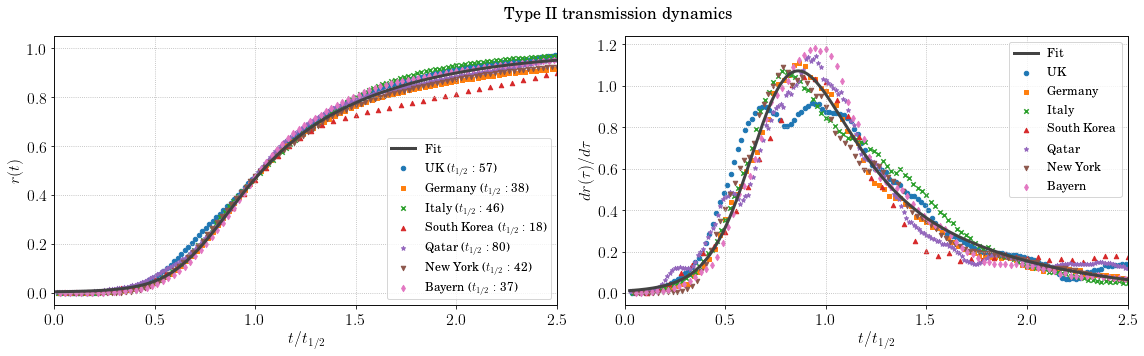

In [5]:
country = ['UK', 'Germany', 'Italy', 'South Korea', 'Qatar', 'New York', 'Bayern']
startdate = ['2020-3-1','2020-3-1', '2020-2-20', '2020-2-18', '2020-3-20', '2020-3-5', '2020-3-1']
datet_max = ['2020-8-1', '2020-7-15', '2020-7-15', '2020-5-1', '2020-11-1', '2020-8-1', '2020-7-15']
markers = ['o', 's', 'x', '^', '*', 'v', 'd']

plt.figure(figsize=(16,5))
plt, regressor_t2, spline_t2 = analyze(countries, country, startdate, datet_max, markers, plt, model='PBC')

x_p = np.linspace(0,2.5,100000)
y_p = interpolate.splev(x_p, spline_t2, der=0)
y_d = interpolate.splev(x_p, spline_t2, der=1)
data = np.vstack((x_p, y_p, y_d))
np.savetxt('data/type2-DNN.txt', data)
t_fact_2 = x_p[argrelextrema(y_d, np.greater)[0]][0]

plt.suptitle('Type II transmission dynamics', fontsize=16, x=0.54)
plt.tight_layout()
plt.savefig('../plots/universal_2_DNN.pdf', facecolor='white', dpi=300)
plt.show()